In [26]:
import glob
import os
import sys
from typing import List, Tuple
sys.path.insert(0, "../src")

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from PIL import Image
import torch
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms as tvt

from config_manager.manager import Params
from model.cascade_net import CascadeNet
from utils.utils import read_json


plt.style.use("dark_background")

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
SAVE_PATH = "../output/experiment"

NUM_CASCADES = 1

param_dict = {
    "data_path": "../output/caesar",#"../output/dataset_20230207-134027",
    "save_path": SAVE_PATH,
    "tb_path": os.path.join(SAVE_PATH, "pcd"),
    "height": 720,
    "width": 1280,
    "resize": 224,
    "scale": 2.0,
    "num_encodings": 6,
    "out_channels": [1 for _ in range(NUM_CASCADES)],
    "filters": [[64, 64, 128, 256, 512, 512, 512, 512] for _ in range(NUM_CASCADES)],
    "kernels": [[3, 3, 3, 3, 3, 3, 3, 3] for _ in range(NUM_CASCADES)],
    "style_nodes": [f"net_stack.{NUM_CASCADES - 1}.encoder.{i + 1}.activation" for i in range(3)],
    "cascade_layers": [f"net_stack.{i}.out_conv.activation" for i in range(NUM_CASCADES - 1)],
    "output_layer": f"net_stack.{NUM_CASCADES - 1}.out_conv.activation",
}

params = Params(param_dict)
print(params)

{'data_path': '../output/caesar', 'save_path': '../output/experiment', 'tb_path': '../output/experiment\\pcd', 'height': 720, 'width': 1280, 'resize': 224, 'scale': 2.0, 'num_encodings': 6, 'out_channels': [1], 'filters': [[64, 64, 128, 256, 512, 512, 512, 512]], 'kernels': [[3, 3, 3, 3, 3, 3, 3, 3]], 'style_nodes': ['net_stack.0.encoder.1.activation', 'net_stack.0.encoder.2.activation', 'net_stack.0.encoder.3.activation'], 'cascade_layers': [], 'output_layer': 'net_stack.0.out_conv.activation'}


# Read images

In [28]:
#idx = np.random.randint(0, 320)
idx = np.random.randint(0, 4308)
idx

791

In [29]:
img_list = glob.glob(params.data_path + "/**/*.png", recursive=True)
bim = img_list[idx]
#fim = img_list[idx + 320]
fim = img_list[idx + 4308]
print(bim)
print(fim)

../output/caesar\back\CSR1301A_0.png
../output/caesar\front\CSR1301A_0.png


In [30]:
def load_img(img_path: str, params: Params) -> Tuple[np.ndarray, torch.Tensor]:
    """Load image and transform to get a tensor for inference"""
    img = np.asarray(Image.open(img_path))
    img_tensor = torch.tensor(img, dtype=torch.float32)

    mask = img_tensor > 0.0
    min_ = img_tensor[mask].min()
    max_ = img_tensor.max()
    img_tensor[mask] = ((img_tensor[mask] - min_) / (max_ - min_))
    result = img_tensor.unsqueeze(0)

    result = tvt.functional.affine(result, shear=0.0, scale=params.scale, translate=(0, 0), angle=0.0)
    rsz = tvt.Resize((params.resize, params.resize), interpolation=tvt.InterpolationMode.NEAREST)
    result = rsz(result)

    return img, result.unsqueeze(0)

In [31]:
img_np, img_tensor = load_img(fim, params)
img_tensor.shape

torch.Size([1, 1, 224, 224])

In [32]:
print(img_np.max())
print(img_np.min())
print(img_np.dtype)
print()
print(img_tensor.max())
print(img_tensor.min())
print(img_tensor.dtype)

31663
0
int32

tensor(1.)
tensor(0.)
torch.float32


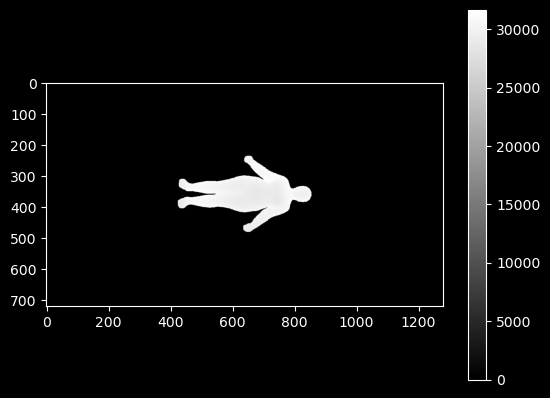

In [33]:
plt.imshow(img_np, cmap="gray")
plt.colorbar();

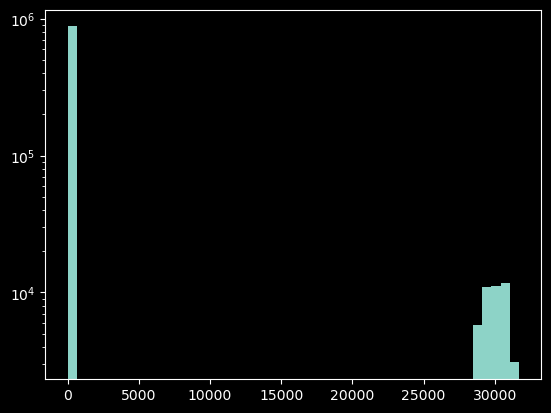

In [34]:
counts, bins = np.histogram(img_np, bins=50)
plt.stairs(counts, bins, fill=True)
plt.semilogy();

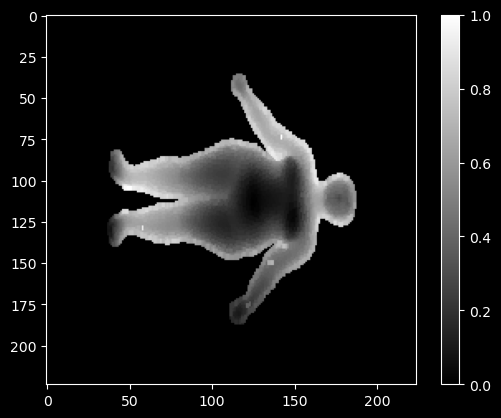

In [35]:
plt.imshow(img_tensor.squeeze().numpy(), cmap="gray")
plt.colorbar();

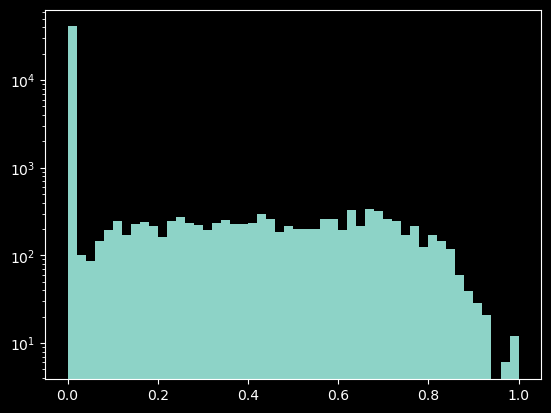

In [36]:
counts, bins = np.histogram(img_tensor.squeeze().numpy(), bins=50)
plt.stairs(counts, bins, fill=True)
plt.semilogy();

# Load model

In [37]:
base_model = CascadeNet(params)
NODES = params.style_nodes + params.cascade_layers + [params.output_layer]
net = create_feature_extractor(base_model, return_nodes=NODES)
net.load_state_dict(
    torch.load(os.path.join(params.save_path, "best_net_c.pt"), map_location=torch.device('cpu'))
)

<All keys matched successfully>

# Evaluate

In [38]:
_, back_img_tensor = load_img(bim, params)

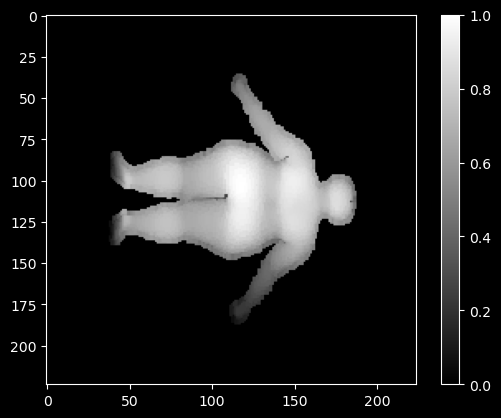

In [39]:
plt.imshow(back_img_tensor.squeeze().numpy(), cmap="gray")
plt.colorbar();

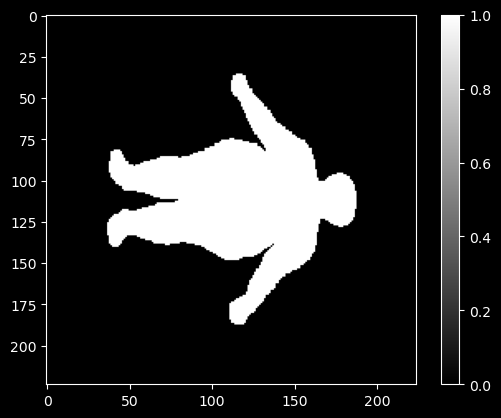

In [40]:
mask = (img_tensor > 0.0).to(torch.float32)
#mask = (back_img_tensor > 0.0).to(torch.float32)

plt.imshow(mask.squeeze().numpy(), cmap="gray")
plt.colorbar();

In [41]:
net.eval()
with torch.no_grad():
    pred = net(img_tensor, mask)
out = pred[params.output_layer]
print(out.max())
print(out.min())
print(out.dtype)

tensor(0.9980)
tensor(1.4300e-14)
torch.float32


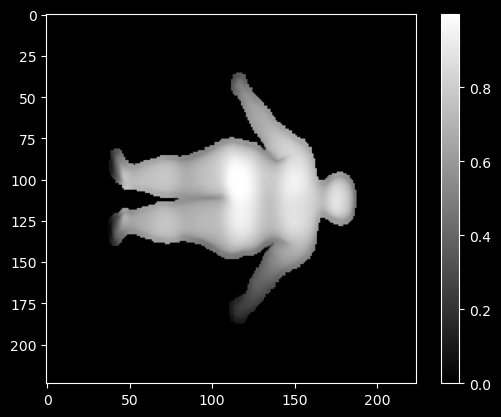

In [42]:
plt.imshow(out.squeeze().numpy(), cmap="gray")
plt.colorbar();

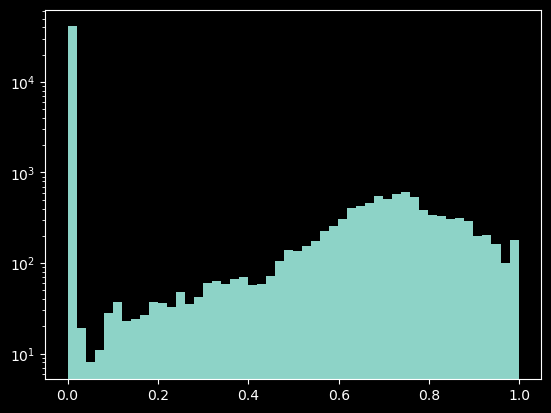

In [43]:
counts, bins = np.histogram(out.squeeze().numpy(), bins=50)
plt.stairs(counts, bins, fill=True)
plt.semilogy();

# Un-normalize

In [44]:
def unnormalize_prediction(img: torch.Tensor, img_np: np.ndarray, params: Params) -> np.ndarray:
    """Unnormalize prediction to get original scale"""
    rsz = tvt.Resize((params.height, params.width), interpolation=tvt.InterpolationMode.NEAREST)
    result = rsz(img)
    result = tvt.functional.affine(
        result, shear=0.0, scale=1/params.scale, translate=(0, 0), angle=0.0
    )

    mask = img_np > 0.0
    min_ = img_np[mask].min()
    max_ = img_np.max()

    result = result.squeeze()

    result[mask] = (result[mask] * (max_ - min_)) + min_

    return result.numpy().astype("int16")

In [45]:
res = unnormalize_prediction(out, img_np, params)
print(res.max())
print(res.min())
print(res.dtype)
print(res.shape)

31656
0
int16
(720, 1280)


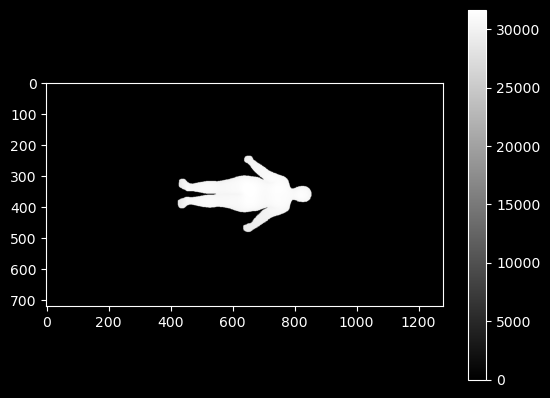

In [46]:
plt.imshow(res, cmap="gray")
plt.colorbar();

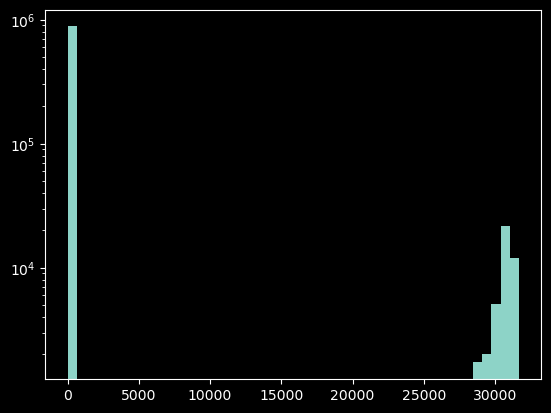

In [47]:
counts, bins = np.histogram(res, bins=50)
plt.stairs(counts, bins, fill=True)
plt.semilogy();

# View 3D

In [48]:
json_files = glob.glob(params.data_path + "/**/*.json", recursive=True)

intrinsic = o3d.camera.PinholeCameraIntrinsic(
    **read_json(list(filter(lambda x: "intrinsic" in x, json_files))[0])
)
extrinsic = read_json(list(filter(lambda x: "extrinsic" in x, json_files))[0])["extrinsics"]
scale = read_json(list(filter(lambda x: "scale" in x, json_files))[0])["depth_scale"]

In [49]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    o3d.geometry.Image(res),
    intrinsic,
    extrinsic,
    depth_scale=scale,
    depth_trunc=4000.0
)

front_pcd = o3d.geometry.PointCloud.create_from_depth_image(
    o3d.geometry.Image(img_np.astype("uint16")),
    intrinsic,
    extrinsic,
    depth_scale=scale,
    depth_trunc=4000.0
)

back_orig_img = np.asarray(Image.open(bim))
back_pcd = o3d.geometry.PointCloud.create_from_depth_image(
    o3d.geometry.Image(back_orig_img.astype("uint16")),
    intrinsic,
    extrinsic,
    depth_scale=scale,
    depth_trunc=4000.0
)

_, ind = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=1.0)
#_, ind = pcd.remove_radius_outlier(nb_points=35, radius=20.0)
inlier_cloud = pcd.select_by_index(ind)

o3d.visualization.draw_geometries([inlier_cloud])
#o3d.visualization.draw_geometries([inlier_cloud, front_pcd])
#o3d.visualization.draw_geometries([back_pcd, inlier_cloud.translate((0, 650, 0))])

[Open3D WARNING] GLFW Error: Win32: Failed to convert clipboard to string: The operation completed successfully. 


In [50]:
# from open3d.visualization.tensorboard_plugin import summary
# from open3d.visualization.tensorboard_plugin.util import to_dict_batch
# from torch.utils.tensorboard import SummaryWriter

In [51]:
# writer = SummaryWriter(params.tb_path)
# writer.add_3d("pcd", to_dict_batch([pcd]), step=0)
# writer.close()

In [52]:
# os.environ["TENSORBOARD_BINARY"] = "/opt/conda/envs/cv3d-env/bin/tensorboard"

In [53]:
# %tensorboard --logdir ../output/experiment/pcd